# Baseline BERT Model

In [1]:
# Append the directory containing the src folder to sys.path
import sys

sys.path.append('/Users/lars/Documents/Uni/Masterarbeit/Online_Process_Concept_Drift')

In [2]:
%pip list

Package                       Version
----------------------------- --------------
absl-py                       1.4.0
aioboto3                      12.4.0
aiobotocore                   2.12.3
aiohttp                       3.9.5
aioitertools                  0.11.0
aiosignal                     1.3.1
annotated-types               0.6.0
anyio                         4.3.0
appnope                       0.1.4
argon2-cffi                   23.1.0
argon2-cffi-bindings          21.2.0
arrow                         1.3.0
asttokens                     2.4.1
astunparse                    1.6.3
async-lru                     2.0.4
async-timeout                 4.0.3
attrs                         23.2.0
Babel                         2.15.0
beautifulsoup4                4.12.3
bleach                        6.1.0
boto3                         1.34.69
botocore                      1.34.69
cachetools                    5.3.3
certifi                       2024.2.2
cffi                          1.16.0
c

In [3]:
#%pip install /Users/lars/Downloads/tensorflow_text-2.15.0-cp310-cp310-macosx_11_0_arm64.whl

Processing /Users/lars/Downloads/tensorflow_text-2.15.0-cp310-cp310-macosx_11_0_arm64.whl
tensorflow-text is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
You should consider upgrading via the '/Users/lars/Documents/test/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
#%pip install -U "tf-models-official==2.15.*"

You should consider upgrading via the '/Users/lars/Documents/test/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

In [2]:
#Path variables for datasets
directory = "/Users/lars/Documents/Uni/Masterarbeit/Online_Process_Concept_Drift"
path_raw = "/data/raw/"
path_interim = "/data/interim/"
path_processed = "/data/processed/"

In [1]:
import tensorflow as tf

In [4]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import tensorflow_text as text
import tensorflow_hub as hub
from src.data.data_manager import data_loader, save_event_log, delete_dataframes
import numpy as np
#import transformers
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score

TensorFlow version: 2.15.0


In [2]:
#print("Transformer version:", transformers.__version__)

NameError: name 'transformers' is not defined

In [5]:
print("TensorFlow version:", text.__version__)

TensorFlow version: 2.15.0


In [6]:
hub.__version__

'0.16.1'

In [58]:
train_tensor = data_loader(directory, path_interim, "Long_BPIC2018_train")
val_tensor = data_loader(directory, path_interim, "BPIC2012_val")
test_tensor = data_loader(directory, path_interim, "PIC2012_test")

In [59]:
train_tensor

,Prefix_Trace,Next_Activity
0,mail-income,mail-valid
1,mail-income mail-valid,mail-valid
2,mail-income mail-valid mail-valid,mail-valid
3,mail-income mail-valid mail-valid mail-valid,initialize
4,mail-income mail-valid mail-valid mail-valid i...,begin-editing
...,...,...
1409175,mail-valid mail-income initialize begin-editin...,abort-payment
1409176,mail-valid mail-income initialize begin-editin...,begin-payment
1409177,mail-valid mail-income initialize begin-editin...,insert-document
1409178,mail-valid mail-income initialize begin-editin...,finish-payment


In [82]:
class BERTPreprocessor2:
    def __init__(self, default_max_length=512):
        self.preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", trainable=False)
        self.default_max_length = default_max_length
        self.max_length = default_max_length
        self.activity_to_label = {}
        self.label_to_activity = {}
        self.next_label_index = 0

    def fit_activity_labels(self, df):
        activities = df['Next_Activity'].unique()
        self.activity_to_label = {activity: idx for idx, activity in enumerate(activities)}
        self.label_to_activity = {idx: activity for activity, idx in self.activity_to_label.items()}
        self.next_label_index = len(activities)

    def calculate_max_length(self, text_inputs):
        processed = self.preprocessor(text_inputs)
        tokenized_lengths = [len(seq) for seq in processed['input_word_ids']]
        self.max_length = min(max(tokenized_lengths), self.default_max_length)

    def preprocess(self, df):
        text_inputs = df['Prefix_Trace'].tolist()
        
        # Dynamically calculate the max length based on the dataset
        self.calculate_max_length(text_inputs)

        labels = []
        for next_activity in df['Next_Activity']:
            if next_activity not in self.activity_to_label:
                self.activity_to_label[next_activity] = self.next_label_index
                self.label_to_activity[self.next_label_index] = next_activity
                self.next_label_index += 1
            labels.append(self.activity_to_label[next_activity])

        labels = tf.convert_to_tensor(labels)

        # Create the dataset directly from text inputs
        dataset = tf.data.Dataset.from_tensor_slices(text_inputs)

        def preprocess_text(text):
            processed = self.preprocessor([text])
            input_word_ids = tf.keras.preprocessing.sequence.pad_sequences(processed['input_word_ids'], maxlen=self.max_length, padding='post')
            input_mask = tf.keras.preprocessing.sequence.pad_sequences(processed['input_mask'], maxlen=self.max_length, padding='post')
            input_type_ids = tf.keras.preprocessing.sequence.pad_sequences(processed['input_type_ids'], maxlen=self.max_length, padding='post')
            return input_word_ids[0], input_mask[0], input_type_ids[0]

        # Apply preprocessing in batches and in parallel
        dataset = dataset.map(lambda text: tf.py_function(func=preprocess_text, inp=[text], Tout=[tf.int32, tf.int32, tf.int32]),
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
        
        dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE).cache()

        # Collect the batches and concatenate them into single tensors
        input_word_ids, input_mask, input_type_ids = [], [], []

        for batch in dataset:
            input_word_ids.append(batch[0])
            input_mask.append(batch[1])
            input_type_ids.append(batch[2])

        input_word_ids = tf.concat(input_word_ids, axis=0)
        input_mask = tf.concat(input_mask, axis=0)
        input_type_ids = tf.concat(input_type_ids, axis=0)

        with tf.device('/device:GPU:0'):
            input_word_ids = tf.convert_to_tensor(input_word_ids)
            input_mask = tf.convert_to_tensor(input_mask)
            input_type_ids = tf.convert_to_tensor(input_type_ids)

        preprocessed_text = {
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids,
            'labels': labels
        }

        return preprocessed_text


In [83]:
preprocessor = BERTPreprocessor2()
preprocessor.fit_activity_labels(train_tensor)
bert_input_train = preprocessor.preprocess(train_tensor)

ValueError: Trying to load a model of incompatible/unknown type. '/var/folders/y4/8sy7dhwd6bb0_t829h6cnw900000gn/T/tfhub_modules/602d30248ff7929470db09f7385fc895e9ceb4c0' contains neither 'saved_model.pb' nor 'saved_model.pbtxt'.

In [32]:
bert_input_val = preprocessor.preprocess(val_tensor)

In [36]:
bert_input_val

{'input_word_ids': <tf.Tensor: shape=(300126, 128), dtype=int32, numpy=
 array([[ 101, 5653, 1011, ...,    0,    0,    0],
        [ 101, 5653, 1011, ...,    0,    0,    0],
        [ 101, 5653, 1011, ...,    0,    0,    0],
        ...,
        [ 101, 5653, 1011, ...,    0,    0,    0],
        [ 101, 5653, 1011, ...,    0,    0,    0],
        [ 101, 5653, 1011, ...,    0,    0,    0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(300126, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(300126, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,

In [37]:
import pickle

# Save the dictionary using pickle
with open('/Users/lars/Documents/test/data/processed/BPIC2018_train_input.pkl', 'wb') as file:
    pickle.dump(bert_input_train, file)

In [39]:
with open('/Users/lars/Documents/test/data/processed/BPIC2018_val_input.pkl', 'wb') as file:
    pickle.dump(bert_input_val, file)

In [26]:
import pickle
import tensorflow as tf

# Load the dictionary using pickle
with open('/Users/lars/Documents/test/data/processed/BPIC2012_train_input.pkl', 'rb') as file:
    loaded_data_dict = pickle.load(file)

# Ensure the tensors are converted back correctly
loaded_data_dict = {key: tf.convert_to_tensor(value) for key, value in loaded_data_dict.items()}


In [27]:
loaded_data_dict

{'input_word_ids': <tf.Tensor: shape=(73271, 128), dtype=int32, numpy=
 array([[ 101, 1037, 1035, ...,    0,    0,    0],
        [ 101, 1037, 1035, ...,    0,    0,    0],
        [ 101, 1037, 1035, ...,    0,    0,    0],
        ...,
        [ 101, 1037, 1035, ...,    0,    0,    0],
        [ 101, 1037, 1035, ...,    0,    0,    0],
        [ 101, 1037, 1035, ...,    0,    0,    0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(73271, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(73271, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 '

# Test

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                           

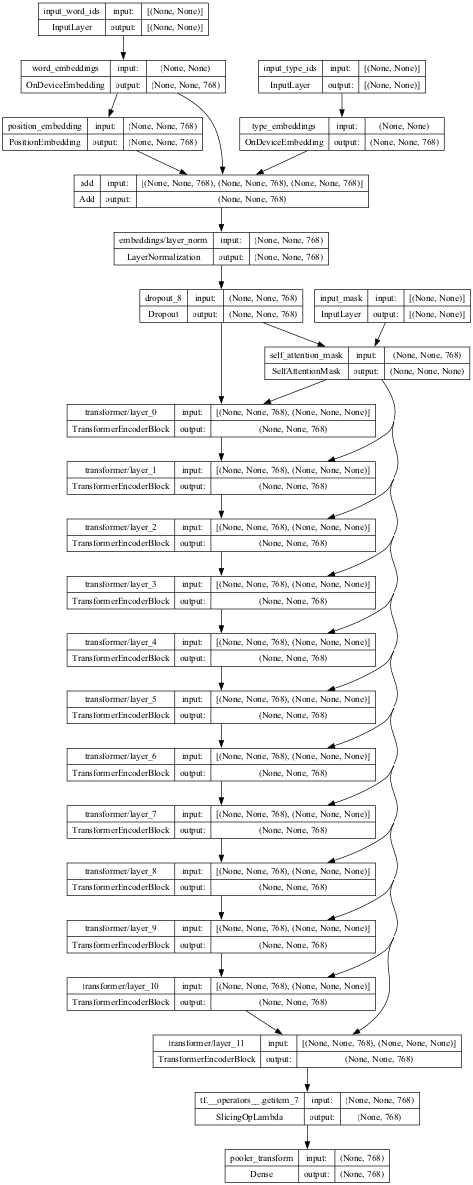

In [34]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_models as tfm

def create_detailed_bert_model(num_classes, max_length=128):
    # Define the input layers for tokenized inputs
    input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_type_ids")

    # Define the encoder configuration
    config_dict = {
        'vocab_size': 30522,
        'hidden_size': 768,
        'num_hidden_layers': 12,
        'num_attention_heads': 12,
        'intermediate_size': 3072,
        'hidden_act': 'gelu',
        'hidden_dropout_prob': 0.1,
        'attention_probs_dropout_prob': 0.1,
        'max_position_embeddings': 512,
        'type_vocab_size': 2,
        'initializer_range': 0.02,
        'layer_norm_eps': 1e-12
    }

    encoder_config = tfm.nlp.encoders.EncoderConfig({
        'type': 'bert',
        'bert': config_dict
    })

    # Build the BERT encoder
    bert_encoder = tfm.nlp.encoders.build_encoder(encoder_config)

    # Pass the inputs to the BERT layer
    bert_outputs = bert_encoder([input_word_ids, input_mask, input_type_ids])
    
    # Get the pooled output from BERT
    pooled_output = bert_outputs['pooled_output']
    
    # Add a dropout layer for regularization
    dropout = tf.keras.layers.Dropout(rate=0.1)(pooled_output)
    
    # Output layer for classification
    output = tf.keras.layers.Dense(num_classes, activation='softmax', name="classifier")(dropout)

    # Create the model
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    
    return model, bert_encoder

# Example usage
num_classes = 10  # Replace with the actual number of classes

# Create the detailed BERT model
model, bert_encoder = create_detailed_bert_model(num_classes)

# Print the model summary
model.summary()

# Plot the detailed model architecture
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)


In [11]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.sequence import pad_sequences

class BERTPreprocessor:
    '''
    The BERTPreprocessor class is designed to preprocess event log data for input into a BERT model from TensorFlow Hub. 
    It tokenizes prefix traces and maps next activities to integer class labels suitable for multi-class classification tasks.

    Attributes:
        - preprocessor: hub.KerasLayer - the preprocessor used to convert text into BERT-compatible tokens.
        - max_length: int - the maximum sequence length for tokenized inputs.
        - activity_to_label: dict - a mapping from activity names to integer class labels.
        - label_to_activity: dict - a mapping from integer class labels to activity names.
        - next_label_index: int - the next available index for new class labels.

    Methods:
        - fit_activity_labels(df): Fits activity labels from the training dataframe.
        - preprocess(df): Preprocesses the input dataframe and returns a dictionary containing BERT-compatible inputs and labels.
    '''

    def __init__(self, max_length=512):
        '''
        Initializes the BERTPreprocessor with a specified maximum sequence length.

        Input:
            - max_length (optional): int - maximum length for tokenized sequences. Default is 512.
        '''

        self.preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
        self.max_length = max_length
        self.activity_to_label = {}
        self.label_to_activity = {}
        self.next_label_index = 0

    def fit_activity_labels(self, df):
        '''
        Fits the activity labels from the provided dataframe, creating a mapping from activity names to integer class labels.

        Input:
            - df: dataframe - dataframe containing event data with a 'Next_Activity' column.
        '''
        activities = df['Next_Activity'].unique()
        self.activity_to_label = {activity: idx for idx, activity in enumerate(activities)}
        self.label_to_activity = {idx: activity for activity, idx in self.activity_to_label.items()}
        self.next_label_index = len(activities)

    def preprocess(self, df):
        '''
        Preprocesses the input dataframe by tokenizing the prefix traces and mapping next activities to integer class labels.
        Returns a dictionary containing BERT-compatible inputs and labels.

        Input:
            - df: dataframe - dataframe containing event data with 'Prefix_Trace' and 'Next_Activity' columns.

        Output:
            - A dictionary with the following keys:
                - input_word_ids: tensor - token IDs for each prefix trace.
                - input_mask: tensor - attention masks indicating real tokens and padding tokens.
                - input_type_ids: tensor - token type IDs (all zeros for single sentences).
                - labels: tensor - integer class labels for the next activities.
        '''
        # Preprocess text data
        text_inputs = df['Prefix_Trace'].tolist()
        preprocessed_text = self.preprocessor(text_inputs)
        
        # Extract the tokenized inputs
        input_word_ids = pad_sequences(preprocessed_text['input_word_ids'], maxlen=self.max_length, padding='post')
        input_mask = pad_sequences(preprocessed_text['input_mask'], maxlen=self.max_length, padding='post')
        input_type_ids = pad_sequences(preprocessed_text['input_type_ids'], maxlen=self.max_length, padding='post')

        # Map next activities to integer class labels
        labels = []
        for next_activity in df['Next_Activity']:
            if next_activity not in self.activity_to_label:
                self.activity_to_label[next_activity] = self.next_label_index
                self.label_to_activity[self.next_label_index] = next_activity
                self.next_label_index += 1
            labels.append(self.activity_to_label[next_activity])

        # Convert to tensors
        input_word_ids = tf.convert_to_tensor(input_word_ids)
        input_mask = tf.convert_to_tensor(input_mask)
        input_type_ids = tf.convert_to_tensor(input_type_ids)
        labels = tf.convert_to_tensor(labels)

        # Prepare the output dictionary
        preprocessed_text = {
            'input_mask': input_mask,
            'input_type_ids': input_type_ids,
            'input_word_ids': input_word_ids,
            'labels': labels
        }

        return preprocessed_text


# Create preprocessor
preprocessor = BERTPreprocessor(max_length=512)

# Fit activity labels
preprocessor.fit_activity_labels(train_tensor)

# Preprocess data
preprocessed_data = preprocessor.preprocess(train_tensor)

# Access the labels
labels = preprocessed_data['labels']
print(preprocessed_data)

{'input_mask': <tf.Tensor: shape=(13175, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'input_type_ids': <tf.Tensor: shape=(13175, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'input_word_ids': <tf.Tensor: shape=(13175, 512), dtype=int32, numpy=
array([[  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       ...,
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0]], dtyp

In [ ]:
class BERTPreprocessor:
    def __init__(self, max_length=512):
        self.preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", trainable=False)
        self.max_length = max_length
        self.activity_to_label = {}
        self.label_to_activity = {}
        self.next_label_index = 0

    def fit_activity_labels(self, df):
        activities = df['Next_Activity'].unique()
        self.activity_to_label = {activity: idx for idx, activity in enumerate(activities)}
        self.label_to_activity = {idx: activity for activity, idx in self.activity_to_label.items()}
        self.next_label_index = len(activities)

    def preprocess(self, df):
        text_inputs = df['Prefix_Trace'].tolist()
        labels = []
        for next_activity in df['Next_Activity']:
            if next_activity not in self.activity_to_label:
                self.activity_to_label[next_activity] = self.next_label_index
                self.label_to_activity[self.next_label_index] = next_activity
                self.next_label_index += 1
            labels.append(self.activity_to_label[next_activity])

        labels = tf.convert_to_tensor(labels)

        def generator():
            for text in text_inputs:
                yield text

        dataset = tf.data.Dataset.from_generator(generator, output_types=tf.string)

        def preprocess_text(text):
            processed = self.preprocessor([text])
            input_word_ids = tf.keras.preprocessing.sequence.pad_sequences(processed['input_word_ids'], maxlen=self.max_length, padding='post')
            input_mask = tf.keras.preprocessing.sequence.pad_sequences(processed['input_mask'], maxlen=self.max_length, padding='post')
            input_type_ids = tf.keras.preprocessing.sequence.pad_sequences(processed['input_type_ids'], maxlen=self.max_length, padding='post')
            return input_word_ids[0], input_mask[0], input_type_ids[0]

        dataset = dataset.map(lambda text: tf.py_function(func=preprocess_text, inp=[text], Tout=[tf.int32, tf.int32, tf.int32]))
        dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

        input_word_ids, input_mask, input_type_ids = [], [], []

        for batch in dataset:
            input_word_ids.append(batch[0])
            input_mask.append(batch[1])
            input_type_ids.append(batch[2])

        input_word_ids = tf.concat(input_word_ids, axis=0)
        input_mask = tf.concat(input_mask, axis=0)
        input_type_ids = tf.concat(input_type_ids, axis=0)

        with tf.device('/device:GPU:0'):
            input_word_ids = tf.convert_to_tensor(input_word_ids)
            input_mask = tf.convert_to_tensor(input_mask)
            input_type_ids = tf.convert_to_tensor(input_type_ids)

        preprocessed_text = {
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids,
            'labels': labels
        }

        return preprocessed_text


In [ ]:
#preprocessor = BERTPreprocessor(max_length=512)
#preprocessor.fit_activity_labels(train_tensor)  # Fit activity labels on the training set

#bert_input_train = preprocessor.preprocess(train_tensor)
#bert_input_val = preprocessor.preprocess(val_tensor)


print(bert_input_train)

In [ ]:
class BERTPreprocessor:
    def __init__(self, default_max_length=512):
        self.preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", trainable=False)
        self.default_max_length = default_max_length
        self.max_length = default_max_length
        self.activity_to_label = {}
        self.label_to_activity = {}
        self.next_label_index = 0

    def fit_activity_labels(self, df):
        activities = df['Next_Activity'].unique()
        self.activity_to_label = {activity: idx for idx, activity in enumerate(activities)}
        self.label_to_activity = {idx: activity for activity, idx in self.activity_to_label.items()}
        self.next_label_index = len(activities)

    def calculate_max_length(self, text_inputs):
        processed = self.preprocessor(text_inputs)
        tokenized_lengths = [len(seq) for seq in processed['input_word_ids']]
        self.max_length = min(max(tokenized_lengths), self.default_max_length)

    def preprocess(self, df):
        text_inputs = df['Prefix_Trace'].tolist()
        
        # Dynamically calculate the max length based on the dataset
        self.calculate_max_length(text_inputs)

        labels = []
        for next_activity in df['Next_Activity']:
            if next_activity not in self.activity_to_label:
                self.activity_to_label[next_activity] = self.next_label_index
                self.label_to_activity[self.next_label_index] = next_activity
                self.next_label_index += 1
            labels.append(self.activity_to_label[next_activity])

        labels = tf.convert_to_tensor(labels)

        # Create the dataset directly from text inputs
        dataset = tf.data.Dataset.from_tensor_slices(text_inputs)

        def preprocess_text(text):
            processed = self.preprocessor([text])
            input_word_ids = tf.keras.preprocessing.sequence.pad_sequences(processed['input_word_ids'], maxlen=self.max_length, padding='post')
            input_mask = tf.keras.preprocessing.sequence.pad_sequences(processed['input_mask'], maxlen=self.max_length, padding='post')
            input_type_ids = tf.keras.preprocessing.sequence.pad_sequences(processed['input_type_ids'], maxlen=self.max_length, padding='post')
            return input_word_ids[0], input_mask[0], input_type_ids[0]

        # Apply preprocessing in batches and in parallel
        dataset = dataset.map(lambda text: tf.py_function(func=preprocess_text, inp=[text], Tout=[tf.int32, tf.int32, tf.int32]),
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
        
        dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE).cache()

        # Collect the batches and concatenate them into single tensors
        input_word_ids, input_mask, input_type_ids = [], [], []

        for batch in dataset:
            input_word_ids.append(batch[0])
            input_mask.append(batch[1])
            input_type_ids.append(batch[2])

        input_word_ids = tf.concat(input_word_ids, axis=0)
        input_mask = tf.concat(input_mask, axis=0)
        input_type_ids = tf.concat(input_type_ids, axis=0)

        with tf.device('/device:GPU:0'):
            input_word_ids = tf.convert_to_tensor(input_word_ids)
            input_mask = tf.convert_to_tensor(input_mask)
            input_type_ids = tf.convert_to_tensor(input_type_ids)

        preprocessed_text = {
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids,
            'labels': labels
        }

        return preprocessed_text


In [ ]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.exceptions import UndefinedMetricWarning
import warnings

# Set the environment variable for GPU memory management
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Enable mixed precision for better performance and reduced memory usage
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Clear any existing GPU memory state
tf.keras.backend.clear_session()

# Reduce TensorFlow logging verbosity
tf.get_logger().setLevel('ERROR')

# Define a class to build the BERT model
class BERTModelBuilder:
    def __init__(self, preprocessor_url, encoder_url, num_classes, max_length=512):
        self.preprocessor_url = preprocessor_url
        self.encoder_url = encoder_url
        self.num_classes = num_classes
        self.max_length = max_length

    def create_model(self):
        preprocessor = hub.KerasLayer(self.preprocessor_url, name='preprocessing')
        encoder = hub.KerasLayer(self.encoder_url, trainable=True, name='BERT_encoder')

        input_word_ids = tf.keras.layers.Input(shape=(self.max_length,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.layers.Input(shape=(self.max_length,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.layers.Input(shape=(self.max_length,), dtype=tf.int32, name='input_type_ids')

        encoder_inputs = {
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids
        }
        encoder_outputs = encoder(encoder_inputs)
        pooled_output = encoder_outputs['pooled_output']

        dropout = tf.keras.layers.Dropout(rate=0.3)(pooled_output)
        output = tf.keras.layers.Dense(self.num_classes, activation='softmax', dtype='float32',
                                       kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
        model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      metrics=['accuracy'])
        return model

# Define a custom callback to calculate additional metrics at the end of each epoch
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_data = self.validation_data
        val_pred = self.model.predict(val_data[0])
        val_pred = tf.argmax(val_pred, axis=1)
        val_true = val_data[1]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            f1 = f1_score(val_true, val_pred, average='weighted')
            precision = precision_score(val_true, val_pred, average='weighted', zero_division=0)
            recall = recall_score(val_true, val_pred, average='weighted', zero_division=0)

        print(f' — val_f1: {f1:.4f} — val_precision: {precision:.4f} — val_recall: {recall:.4f}')

# URLs for the BERT model and preprocessor
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

# Number of classes (update this according to your data)
num_classes = 10  # Example value, replace with actual number of classes

# Initialize and create the model
model_builder = BERTModelBuilder(preprocessor_url=tfhub_handle_preprocess, 
                                 encoder_url=tfhub_handle_encoder, 
                                 num_classes=num_classes,
                                 max_length=512)  # Use original max_length

model = model_builder.create_model()
model.summary()

# Assuming your input data is structured correctly
train_data = {
    'input_mask': bert_input_train['input_mask'],
    'input_type_ids': bert_input_train['input_type_ids'],
    'input_word_ids': bert_input_train['input_word_ids']
}

train_labels = bert_input_train['labels']

val_data = {
    'input_mask': bert_input_val['input_mask'],
    'input_type_ids': bert_input_val['input_type_ids'],
    'input_word_ids': bert_input_val['input_word_ids'],
}

val_labels = bert_input_val['labels']

# Ensure labels are in the shape (None,) and integer-encoded
train_labels = tf.squeeze(train_labels)
val_labels = tf.squeeze(val_labels)

# Function to ensure labels are one-dimensional
def ensure_one_dimensional(labels):
    if len(labels.shape) == 2 and labels.shape[1] == 1:
        labels = tf.squeeze(labels, axis=-1)
    return labels

# Apply the function to labels
train_labels = ensure_one_dimensional(train_labels)
val_labels = ensure_one_dimensional(val_labels)

# Confirm the shapes again
print(f"After ensuring one-dimensional, shape of train_labels: {train_labels.shape}")
print(f"After ensuring one-dimensional, shape of val_labels: {val_labels.shape}")

batch_size=4

# Shuffle the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).shuffle(buffer_size=len(train_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
# No need to shuffle the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Train the model with the custom metrics callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

metrics_callback = MetricsCallback(validation_data=(val_data, val_labels))
history_helpdesk = model.fit(
    train_dataset,
    epochs=5,  # Increase the number of epochs
    validation_data=val_dataset,
    callbacks=[metrics_callback, early_stopping_callback]
)

# Save the trained model with a specific name
model_name_helpdesk = "bert_model_helpdesk"
model.save(f'path/to/{model_name_helpdesk}')

# Save the training history
import pickle
with open(f'path/to/history_helpdesk.pkl', 'wb') as file:
    pickle.dump(history_helpdesk.history, file)

# Load the saved model
loaded_model = tf.keras.models.load_model(f'path/to/{model_name}')

# Verify the loaded model
loaded_model.summary()

# Plotting accuracy and loss
def plot_training_history(history):
    # Extracting values from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history)


### LongBERT Test

In [9]:
%pip install transformers==4.31.0

  Using cached transformers-4.31.0-py3-none-any.whl (7.4 MB)
  Using cached tokenizers-0.13.3-cp310-cp310-macosx_12_0_arm64.whl (3.9 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.2
    Uninstalling transformers-4.40.2:
      Successfully uninstalled transformers-4.40.2
You should consider upgrading via the '/Users/lars/Documents/test/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [62]:
import transformers

print(transformers.__version__)


4.31.0


In [9]:
from transformers import LongformerTokenizer
import tensorflow as tf

class LongformerPreprocessor2:
    def __init__(self, model_name='allenai/longformer-base-4096', default_max_length=4096):
        self.tokenizer = LongformerTokenizer.from_pretrained(model_name)
        self.default_max_length = default_max_length
        self.max_length = default_max_length
        self.activity_to_label = {}
        self.label_to_activity = {}
        self.next_label_index = 0

    def fit_activity_labels(self, df):
        activities = df['Next_Activity'].unique()
        self.activity_to_label = {activity: idx for idx, activity in enumerate(activities)}
        self.label_to_activity = {idx: activity for activity, idx in self.activity_to_label.items()}
        self.next_label_index = len(activities)

    def calculate_max_length(self, text_inputs):
        tokenized_lengths = [len(self.tokenizer(text, truncation=False)['input_ids']) for text in text_inputs]
        self.max_length = min(max(tokenized_lengths), self.default_max_length)

    def preprocess(self, df):
        text_inputs = df['Prefix_Trace'].tolist()
        
        # Dynamically calculate the max length based on the dataset
        self.calculate_max_length(text_inputs)

        labels = []
        for next_activity in df['Next_Activity']:
            if next_activity not in self.activity_to_label:
                self.activity_to_label[next_activity] = self.next_label_index
                self.label_to_activity[self.next_label_index] = next_activity
                self.next_label_index += 1
            labels.append(self.activity_to_label[next_activity])

        labels = tf.convert_to_tensor(labels)

        # Tokenize the text inputs
        encodings = self.tokenizer(text_inputs, truncation=True, padding=True, max_length=self.max_length, return_tensors='tf')

        # Check for any out-of-bounds token IDs
        input_ids = encodings['input_ids']
        vocab_size = self.tokenizer.vocab_size
        if tf.reduce_max(input_ids) >= vocab_size:
            print(f"Max token ID: {tf.reduce_max(input_ids)}")
            print(f"Vocabulary size: {vocab_size}")
            raise ValueError("Some token IDs are out of bounds of the tokenizer vocabulary size.")

        preprocessed_text = {
            'input_ids': input_ids,
            'attention_mask': encodings['attention_mask'],
            'labels': labels
        }

        return preprocessed_text, self.max_length  # Return the dynamically calculated max_length


In [42]:
from transformers import LongformerTokenizer
import tensorflow as tf

class LongformerPreprocessor3:
    def __init__(self, model_name='allenai/longformer-base-4096', default_max_length=4096):
        self.tokenizer = LongformerTokenizer.from_pretrained(model_name)
        self.max_length = default_max_length
        self.activity_to_label = {}
        self.label_to_activity = {}
        self.next_label_index = 0

    def fit_activity_labels(self, df):
        activities = df['Next_Activity'].unique()
        self.activity_to_label = {activity: idx for idx, activity in enumerate(activities)}
        self.label_to_activity = {idx: activity for activity, idx in self.activity_to_label.items()}
        self.next_label_index = len(activities)

    def preprocess(self, df):
        text_inputs = df['Prefix_Trace'].tolist()
        

        labels = []
        for next_activity in df['Next_Activity']:
            if next_activity not in self.activity_to_label:
                self.activity_to_label[next_activity] = self.next_label_index
                self.label_to_activity[self.next_label_index] = next_activity
                self.next_label_index += 1
            labels.append(self.activity_to_label[next_activity])

        labels = tf.convert_to_tensor(labels)

        # Tokenize the text inputs
        encodings = self.tokenizer(text_inputs, padding='max_length', max_length=self.max_length, return_tensors='tf')

        # Check for any out-of-bounds token IDs
        input_ids = encodings['input_ids']
        vocab_size = self.tokenizer.vocab_size
        if tf.reduce_max(input_ids) >= vocab_size:
            print(f"Max token ID: {tf.reduce_max(input_ids)}")
            print(f"Vocabulary size: {vocab_size}")
            raise ValueError("Some token IDs are out of bounds of the tokenizer vocabulary size.")

        preprocessed_text = {
            'input_ids': input_ids,
            'attention_mask': encodings['attention_mask'],
            'labels': labels
        }

        return preprocessed_text, self.max_length  # Return the dynamically calculated max_length


In [10]:
import os
from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from tensorflow.keras.callbacks import Callback

# Clear any existing GPU memory state
tf.keras.backend.clear_session()

# Set the environment variable for GPU memory management
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Reduce TensorFlow logging verbosity
tf.get_logger().setLevel('ERROR')

class LongformerModelBuilder2:
    def __init__(self, model_name, num_classes):
        self.model_name = model_name
        self.num_classes = num_classes

    def create_model(self, max_length):
        # Ensure TensorFlow uses the GPU if available
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
            except RuntimeError as e:
                print(e)

        # Load the model
        encoder = TFAutoModel.from_pretrained(self.model_name)

        input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
        attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

        encoder_outputs = encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = encoder_outputs.last_hidden_state[:, 0, :]

        dropout = tf.keras.layers.Dropout(rate=0.3)(pooled_output)
        output = tf.keras.layers.Dense(self.num_classes, activation='softmax', dtype='float32',
                                       kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout)

        model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
        
        model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      metrics=['accuracy'])
        return model

# Define a custom callback to calculate additional metrics at the end of each epoch
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_data = self.validation_data
        val_pred = self.model.predict(val_data)
        val_pred = tf.argmax(val_pred, axis=1)
        val_true = tf.convert_to_tensor(val_labels, dtype=tf.int32)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            f1 = f1_score(val_true, val_pred, average='weighted')
            precision = precision_score(val_true, val_pred, average='weighted', zero_division=0)
            recall = recall_score(val_true, val_pred, average='weighted', zero_division=0)

        print(f' — val_f1: {f1:.4f} — val_precision: {precision:.4f} — val_recall: {recall:.4f}')


In [43]:
# Initialize the preprocessor and preprocess the data
preprocessor = LongformerPreprocessor3(model_name='allenai/longformer-base-4096', default_max_length=242)
bert_input_train, train_max_length = preprocessor.preprocess(train_tensor)
bert_input_val, val_max_length = preprocessor.preprocess(val_tensor)

/Users/lars/Documents/test/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [44]:
print(train_max_length)
print(val_max_length)

242
242


In [45]:
bert_input_train

{'input_ids': <tf.Tensor: shape=(1409180, 242), dtype=int32, numpy=
 array([[   0, 6380,   12, ...,    1,    1,    1],
        [   0, 6380,   12, ...,    1,    1,    1],
        [   0, 6380,   12, ...,    1,    1,    1],
        ...,
        [   0, 6380,   12, ...,    1,    1,    1],
        [   0, 6380,   12, ...,    1,    1,    1],
        [   0, 6380,   12, ...,    1,    1,    1]], dtype=int32)>,
 'attention_mask': <tf.Tensor: shape=(1409180, 242), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'labels': <tf.Tensor: shape=(1409180,), dtype=int32, numpy=array([ 0,  0,  0, ..., 11, 10, 13], dtype=int32)>}

In [46]:
bert_input_val

{'input_ids': <tf.Tensor: shape=(303658, 242), dtype=int32, numpy=
 array([[   0, 6380,   12, ...,    1,    1,    1],
        [   0, 6380,   12, ...,    1,    1,    1],
        [   0, 6380,   12, ...,    1,    1,    1],
        ...,
        [   0, 6380,   12, ...,    1,    1,    1],
        [   0, 6380,   12, ...,    1,    1,    1],
        [   0, 6380,   12, ...,    1,    1,    1]], dtype=int32)>,
 'attention_mask': <tf.Tensor: shape=(303658, 242), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'labels': <tf.Tensor: shape=(303658,), dtype=int32, numpy=array([ 0,  0,  0, ..., 11, 10, 13], dtype=int32)>}

In [ ]:
#train_max_length_helpdesk = 36
#val_max_length_helpdesk = 32

In [ ]:
#train_max_length_bpic2012 = 511
#val_max_length_bpic2012 = 526

In [ ]:
#train_max_length_bpic2018 = 242
#val_max_length_bpic2018 = 242

In [47]:
import pickle

# Assuming bert_input_train contains your preprocessed data
bert_input_train_numpy = {key: tensor.numpy() for key, tensor in bert_input_train.items()}

# Save the dictionary using pickle
with open('/Users/lars/Documents/test/data/processed/Long_bpic2018_train_input.pkl', 'wb') as file:
    pickle.dump(bert_input_train_numpy, file)

In [48]:
import pickle

# Assuming bert_input_train contains your preprocessed data
bert_input_val_numpy = {key: tensor.numpy() for key, tensor in bert_input_val.items()}

# Save the dictionary using pickle
with open('/Users/lars/Documents/test/data/processed/Long_bpic2018_val_input.pkl', 'wb') as file:
    pickle.dump(bert_input_val_numpy, file)

In [60]:
# Load the dictionary using pickle
with open('/Users/lars/Documents/test/data/processed/Long_bpic2018_train_input.pkl', 'rb') as file:
    bert_input_train_numpy = pickle.load(file)

# Convert NumPy arrays back to TensorFlow tensors
bert_input_train = {key: tf.convert_to_tensor(value) for key, value in bert_input_train_numpy.items()}

# Print the loaded data to confirm the conversion
print(bert_input_train)


{'input_ids': <tf.Tensor: shape=(1409180, 242), dtype=int32, numpy=
array([[   0, 6380,   12, ...,    1,    1,    1],
       [   0, 6380,   12, ...,    1,    1,    1],
       [   0, 6380,   12, ...,    1,    1,    1],
       ...,
       [   0, 6380,   12, ...,    1,    1,    1],
       [   0, 6380,   12, ...,    1,    1,    1],
       [   0, 6380,   12, ...,    1,    1,    1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1409180, 242), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'labels': <tf.Tensor: shape=(1409180,), dtype=int32, numpy=array([ 0,  0,  0, ..., 11, 10, 13], dtype=int32)>}


In [61]:
# Load the dictionary using pickle
with open('/Users/lars/Documents/test/data/processed/Long_bpic2018_val_input.pkl', 'rb') as file:
    bert_input_val_numpy = pickle.load(file)

# Convert NumPy arrays back to TensorFlow tensors
bert_input_val = {key: tf.convert_to_tensor(value) for key, value in bert_input_val_numpy.items()}

# Print the loaded data to confirm the conversion
print(bert_input_val)


{'input_ids': <tf.Tensor: shape=(303658, 242), dtype=int32, numpy=
array([[   0, 6380,   12, ...,    1,    1,    1],
       [   0, 6380,   12, ...,    1,    1,    1],
       [   0, 6380,   12, ...,    1,    1,    1],
       ...,
       [   0, 6380,   12, ...,    1,    1,    1],
       [   0, 6380,   12, ...,    1,    1,    1],
       [   0, 6380,   12, ...,    1,    1,    1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(303658, 242), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'labels': <tf.Tensor: shape=(303658,), dtype=int32, numpy=array([ 0,  0,  0, ..., 11, 10, 13], dtype=int32)>}


In [ ]:
max_length = 36
num_classes = 10
batch_size=8

In [18]:
# Use the larger of the two max lengths for the model
max_length = max(train_max_length, val_max_length)
max_length

36

In [19]:
bert_input_train

{'input_ids': <tf.Tensor: shape=(13175, 36), dtype=int32, numpy=
 array([[   0, 2401, 4932, ...,    1,    1,    1],
        [   0, 2401, 4932, ...,    1,    1,    1],
        [   0, 2401, 4932, ...,    1,    1,    1],
        ...,
        [   0, 2401, 4932, ...,    1,    1,    1],
        [   0, 2401, 4932, ...,    1,    1,    1],
        [   0, 2401, 4932, ...,    1,    1,    1]], dtype=int32)>,
 'attention_mask': <tf.Tensor: shape=(13175, 36), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'labels': <tf.Tensor: shape=(13175,), dtype=int32, numpy=array([0, 0, 1, ..., 1, 2, 3], dtype=int32)>}

In [20]:
# Example usage:
model_builder = LongformerModelBuilder2(model_name='allenai/longformer-base-4096', num_classes=num_classes)
model = model_builder.create_model(max_length=max_length)
model.summary()

Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerModel: ['lm_head']
- This IS expected if you are initializing TFLongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFLongformerModel were initialized from the model checkpoint at allenai/longformer-base-4096.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLongformerModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 36)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 36)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf.cast (TFOpLambda)        (None, 36)                   0         ['input_ids[0][0]']           
                                                                                                  
 tf.cast_1 (TFOpLambda)      (None, 36)                   0         ['attention_mask[0][0]']  

In [ ]:
# Assuming your input data is structured correctly
train_data = {
    'input_ids': bert_input_train['input_ids'],  # Assuming input_word_ids correspond to input_ids
    'attention_mask': bert_input_train['attention_mask']
}

train_labels = bert_input_train['labels']

val_data = {
    'input_ids': bert_input_val['input_ids'],  # Assuming input_word_ids correspond to input_ids
    'attention_mask': bert_input_val['attention_mask']
}

val_labels = bert_input_val['labels']

# Ensure labels are in the shape (None,) and integer-encoded
train_labels = tf.squeeze(train_labels)
val_labels = tf.squeeze(val_labels)

# Function to ensure labels are one-dimensional
def ensure_one_dimensional(labels):
    if len(labels.shape) == 2 and labels.shape[1] == 1:
        labels = tf.squeeze(labels, axis=-1)
    return labels

# Apply the function to labels
train_labels = ensure_one_dimensional(train_labels)
val_labels = ensure_one_dimensional(val_labels)

# Confirm the shapes again
print(f"After ensuring one-dimensional, shape of train_labels: {train_labels.shape}")
print(f"After ensuring one-dimensional, shape of val_labels: {val_labels.shape}")

In [ ]:
# Shuffle the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).shuffle(buffer_size=len(train_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
# No need to shuffle the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Define early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

metrics_callback = MetricsCallback(validation_data=val_dataset)

# Assuming you have defined your model (e.g., Longformer model)
history_helpdesk = model.fit(
    train_dataset,
    epochs=5,  # Increase the number of epochs if necessary
    validation_data=val_dataset,
    callbacks=[metrics_callback, early_stopping_callback]
)